In [1]:
import tensorflow as tf

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [4]:
input_file = '../data/baidu_95.csv'

In [58]:
df = pd.read_csv(input_file, header=None).rename(columns={0:"labels", 1:"content"})

In [59]:
df.head()

,labels,content
0,高中 生物 分子与细胞 组成细胞的化学元素 组成细胞的化合物,菠菜从土壤中吸收的氮元素可以用来合成（）A.淀粉和纤维素B.葡萄糖和DNAC.核酸和蛋白质D...
1,高中 生物 稳态与环境 神经调节和体液调节的比较,下列有关生物体内信息传递的叙述，正确的是（）A下丘脑分泌的促甲状腺激素释放激素，可作用于甲状...
2,高中 生物 生物技术实践 生物工程技术,从自然菌样筛选较理想生产菌种的一般步骤是：采集菌样→富集培养→纯种分离→性能测定．1.不同微...
3,高中 生物 生物技术实践 生物技术在其他方面的应用 器官移植 复等位基因 胚胎移植 基因工程...,目前，精子载体法逐渐成为具有诱惑力的制备转基因动物方法之一，该方法以精子作为外源基因的载体，...
4,高中 地理 宇宙中的地球 地球运动的地理意义,某人想乘普通飞机在一年中连续过两次生日，你认为应穿越（）A赤道B两级C本初子午线D国际日期变更线


In [60]:
df.count()

labels     22576
content    22576
dtype: int64

In [61]:
df.describe()

,labels,content
count,22576,22576
unique,673,18419
top,高中 地理 宇宙中的地球 地球运动的地理意义,下列四幅图中，能正确表示地球自转方向的是（）ABCD
freq,1533,12


In [62]:
df["subject"] = df['labels'].apply(lambda x:x.split()[1])

In [63]:
df.head()

,labels,content,subject
0,高中 生物 分子与细胞 组成细胞的化学元素 组成细胞的化合物,菠菜从土壤中吸收的氮元素可以用来合成（）A.淀粉和纤维素B.葡萄糖和DNAC.核酸和蛋白质D...,生物
1,高中 生物 稳态与环境 神经调节和体液调节的比较,下列有关生物体内信息传递的叙述，正确的是（）A下丘脑分泌的促甲状腺激素释放激素，可作用于甲状...,生物
2,高中 生物 生物技术实践 生物工程技术,从自然菌样筛选较理想生产菌种的一般步骤是：采集菌样→富集培养→纯种分离→性能测定．1.不同微...,生物
3,高中 生物 生物技术实践 生物技术在其他方面的应用 器官移植 复等位基因 胚胎移植 基因工程...,目前，精子载体法逐渐成为具有诱惑力的制备转基因动物方法之一，该方法以精子作为外源基因的载体，...,生物
4,高中 地理 宇宙中的地球 地球运动的地理意义,某人想乘普通飞机在一年中连续过两次生日，你认为应穿越（）A赤道B两级C本初子午线D国际日期变更线,地理


In [64]:
def clean_sentence(line):
    line = re.sub(
            "[a-zA-Z0-9]|[\s+\-\|\!\/\[\]\{\}_,.$%^*(+\"\')]+|[:：+——()?【】《》“”！，。？、~@#￥%……&*（）]+|题目", '',line)
    words = jieba.cut(line, cut_all=False)
    
    return words

In [65]:
stopwords_path = "../data/stopwords/哈工大停用词表.txt"

In [66]:
def load_stop_words(stopwords_path):
    with open(stopwords_path, 'r') as f:
        stop_words = [word.strip() for word in f.readlines()]
        stop_words_dict = dict(zip(stop_words, list(range(len(stop_words)))))
    
    return stop_words_dict

In [67]:
from collections import Counter
import re
import jieba
import json

In [76]:
def sentence_proc(sentence):
    # 清除无用词
    cw_words = list(clean_sentence(sentence))
    # print("after clear sentence:", len(list(cw_words)))
    
    # 去除停用词
    sw_words = [word for word in cw_words if word not in load_stop_words(stopwords_path)]
    # print("after clear stop_words:", len(sw_words))
    
    return " ".join(sw_words)

In [114]:
def generate_vocab(contents, labels):
    # 拉平词语
    all_words = [word for content in contents for word in content]
    print("all words:", len(all_words))
    # 去除低频词
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts.items(), key=lambda x:x[1], reverse=True)
    fw_words = [word[0] for word in sorted_words if word[1] > 5]
    print("after clear low frequence:", len(fw_words))
    
    vocab = []
    vocab.append("PAD")
    vocab.append("UNK")
    vocab += fw_words
    # 生成词表
    word2idx = dict(zip(vocab, list(range(len(fw_words)))))
    
    # 将词汇-索引映射表保存为json数据，之后做inference时直接加载来处理数据
    with open("../data/word2idx.json", "w", encoding="utf-8") as f:
        json.dump(word2idx, f)
        
    return word2idx

In [87]:
import numpy as np
from multiprocessing import Pool, cpu_count

# 获取cpu数量
cores = cpu_count()
print("cores: %d" % cores)

# 分块个数
partitions = cores

def parallelize(df, func):
    '''
    多核并行处理模块
    '''
    # 数据拆分
    data_split = np.array_split(df, 10)
    
    # 进程池
    pool = Pool(cores)
    
    # 数据分发，合并
    data = pd.concat(pool.map(func, data_split))
    
    # 关闭进程池
    pool.close()
    
    # 执行完close后不会有新的进程加入到pool.join函数等待所有子进程结束
    pool.join()
    
    return data

cores: 48


In [89]:
def data_fram_proc(df):
    if "content" in df.columns:
        df["content"] = df["content"].apply(sentence_proc)

In [91]:
%%time
df["content"] = df["content"].apply(sentence_proc)

CPU times: user 5min 45s, sys: 45.1 s, total: 6min 31s
Wall time: 6min 7s


In [92]:
df.to_csv("../data/baidu_sentence.csv", index=None, header=True)

In [93]:
df.head()

,labels,content,subject
0,高中 生物 分子与细胞 组成细胞的化学元素 组成细胞的化合物,菠菜 土壤 中 吸收 氮 元素 用来 合成 淀粉 纤维素 葡萄糖 核酸 蛋白质 麦芽糖 脂肪酸,生物
1,高中 生物 稳态与环境 神经调节和体液调节的比较,下列 生物体 内 信息 传递 叙述 正确 下丘脑 分泌 促 甲状腺 激素 释放 激素 作用 ...,生物
2,高中 生物 生物技术实践 生物工程技术,自然 菌样 筛选 理想 生产 菌种 步骤 采集 菌样 富集 培养 纯种 分离 性能 测定 不...,生物
3,高中 生物 生物技术实践 生物技术在其他方面的应用 器官移植 复等位基因 胚胎移植 基因工程...,目前 精子 载体 法 逐渐 成为 具有 诱惑力 制备 转基因 动物 方法 方法 精子 外源 ...,生物
4,高中 地理 宇宙中的地球 地球运动的地理意义,某人 想 普通 飞机 一年 中 连续 两次 生日 认为 应 穿越 赤道 两级 本初子午线 国...,地理


In [94]:
contents = df["content"].tolist()
len(contents)

22576

In [95]:
contents = [content.split() for content in contents]

In [96]:
contents[:1]

[['菠菜',
  '土壤',
  '中',
  '吸收',
  '氮',
  '元素',
  '用来',
  '合成',
  '淀粉',
  '纤维素',
  '葡萄糖',
  '核酸',
  '蛋白质',
  '麦芽糖',
  '脂肪酸']]

In [97]:
labels = df["subject"].tolist()

In [115]:
word2idx = generate_vocab(contents, labels)

all words: 1019403
after clear low frequence: 12602


In [116]:
word2idx

{'PAD': 0,
 'UNK': 1,
 '中': 2,
 '细胞': 3,
 '下列': 4,
 '基因': 5,
 '染色体': 6,
 '正确': 7,
 '过程': 8,
 '不': 9,
 '上': 10,
 '叙述': 11,
 '时': 12,
 '进行': 13,
 '实验': 14,
 '都': 15,
 '产生': 16,
 '后': 17,
 '主要': 18,
 '发展': 19,
 '表示': 20,
 '材料': 21,
 '发生': 22,
 '﹣': 23,
 '中国': 24,
 '植物': 25,
 '基因型': 26,
 '问题': 27,
 '内': 28,
 '不同': 29,
 '经济': 30,
 '年': 31,
 '作用': 32,
 '可能': 33,
 '生物': 34,
 '杂交': 35,
 '形成': 36,
 '地球': 37,
 '我国': 38,
 '错误': 39,
 '如图': 40,
 '图': 41,
 '回答': 42,
 '变化': 43,
 '出现': 44,
 '酶': 45,
 '技术': 46,
 '人': 47,
 '使': 48,
 '植株': 49,
 '具有': 50,
 '分别': 51,
 '遗传': 52,
 '物质': 53,
 '相同': 54,
 '蛋白质': 55,
 '属于': 56,
 '影响': 57,
 '原因': 58,
 '控制': 59,
 '个体': 60,
 '分裂': 61,
 '太阳': 62,
 '正常': 63,
 '分离': 64,
 '社会': 65,
 '方法': 66,
 '胚胎': 67,
 '调节': 68,
 '结构': 69,
 '文化': 70,
 '需要': 71,
 '°': 72,
 '现象': 73,
 '说法': 74,
 '培养': 75,
 '动物': 76,
 '目的': 77,
 '性状': 78,
 '环境': 79,
 '分析': 80,
 '会': 81,
 '利用': 82,
 '下': 83,
 '含有': 84,
 '一定': 85,
 '激素': 86,
 '获得': 87,
 '分子': 88,
 '位于': 89,
 '果蝇': 90,
 '抗体': 91,
 '比例': 92

In [100]:
label2idx = dict(zip(list(set(labels)), range(4)))

In [101]:
label2idx

{'历史': 0, '地理': 1, '生物': 2, '政治': 3}

In [117]:
with open("../data/wordJson/word2idx.json", "w", encoding="utf-8") as f:
    json.dump(word2idx, f)
        
with open("../data/wordJson/label2idx.json", "w", encoding="utf-8") as f:
    json.dump(label2idx, f)

In [103]:
df.head()

,labels,content,subject
0,高中 生物 分子与细胞 组成细胞的化学元素 组成细胞的化合物,菠菜 土壤 中 吸收 氮 元素 用来 合成 淀粉 纤维素 葡萄糖 核酸 蛋白质 麦芽糖 脂肪酸,生物
1,高中 生物 稳态与环境 神经调节和体液调节的比较,下列 生物体 内 信息 传递 叙述 正确 下丘脑 分泌 促 甲状腺 激素 释放 激素 作用 ...,生物
2,高中 生物 生物技术实践 生物工程技术,自然 菌样 筛选 理想 生产 菌种 步骤 采集 菌样 富集 培养 纯种 分离 性能 测定 不...,生物
3,高中 生物 生物技术实践 生物技术在其他方面的应用 器官移植 复等位基因 胚胎移植 基因工程...,目前 精子 载体 法 逐渐 成为 具有 诱惑力 制备 转基因 动物 方法 方法 精子 外源 ...,生物
4,高中 地理 宇宙中的地球 地球运动的地理意义,某人 想 普通 飞机 一年 中 连续 两次 生日 认为 应 穿越 赤道 两级 本初子午线 国...,地理


## 标签和内容数值化

In [104]:
def labelToIndex(sentence):
    with open("../data/wordJson/label2idx.json", "r") as f:
        label2idx = json.load(f)
    return label2idx[sentence]

In [105]:
df["subject"] = df["subject"].apply(labelToIndex)

In [ ]:
word2idx 

In [122]:
def contentToIndex(sentence, word2idx):
    words = sentence.split(" ")
    ids = [word2idx.get(word, word2idx["UNK"]) for word in words]
    return ids

In [124]:
content_ids = df["content"].apply(lambda x:contentToIndex(x, word2idx))

In [126]:
content_ids[0]

[3396, 402, 2, 495, 2481, 605, 1768, 107, 1002, 682, 359, 470, 55, 2290, 3863]

In [135]:
df.head()

,labels,content,subject
0,高中 生物 分子与细胞 组成细胞的化学元素 组成细胞的化合物,菠菜 土壤 中 吸收 氮 元素 用来 合成 淀粉 纤维素 葡萄糖 核酸 蛋白质 麦芽糖 脂肪酸,2
1,高中 生物 稳态与环境 神经调节和体液调节的比较,下列 生物体 内 信息 传递 叙述 正确 下丘脑 分泌 促 甲状腺 激素 释放 激素 作用 ...,2
2,高中 生物 生物技术实践 生物工程技术,自然 菌样 筛选 理想 生产 菌种 步骤 采集 菌样 富集 培养 纯种 分离 性能 测定 不...,2
3,高中 生物 生物技术实践 生物技术在其他方面的应用 器官移植 复等位基因 胚胎移植 基因工程...,目前 精子 载体 法 逐渐 成为 具有 诱惑力 制备 转基因 动物 方法 方法 精子 外源 ...,2
4,高中 地理 宇宙中的地球 地球运动的地理意义,某人 想 普通 飞机 一年 中 连续 两次 生日 认为 应 穿越 赤道 两级 本初子午线 国...,1


In [129]:
import matplotlib.pyplot as plt

In [130]:
x = list(range(len(content_ids)))
y = [len(w) for w in content_ids]

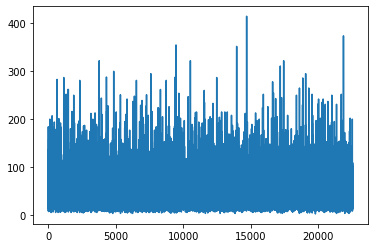

In [133]:
plt.plot(x, y)
plt.show()

In [134]:
def get_max_len(data):
    max_lens = data.apply(lambda x: x.count(" "))
    
    return int(np.mean(max_lens) + 2 * np.std(max_lens))

In [138]:
train_x_max_len = get_max_len(df["content"])
train_x_max_len

108

In [142]:
contents = content_ids.tolist()

In [143]:
labels = df["subject"].tolist()

In [151]:
def generate_train_val_data(x, y, word2idx, max_len, rate=0.8):
    contents = []
    
    for content in x:
        if len(content) >= max_len:
            contents.append(content[:max_len])
        else:
            contents.append(content + [word2idx["PAD"]] * (max_len - len(content)))
            
    split_idx = int(len(x) * rate)
    
    train_data = np.asarray(contents[:split_idx], dtype="int64")
    train_label = np.array(y[:split_idx], dtype="float32")
    
    evl_data = np.asarray(contents[split_idx:], dtype="int64")
    evl_label = np.array(y[split_idx:], dtype="float32")
    
    return train_data, train_label, evl_data, evl_label

In [152]:
train_data, train_label, evl_data, evl_label = generate_train_val_data(contents, labels, word2idx, get_max_len(df["content"]), 0.8)

In [153]:
train_data

array([[3396,  402,    2, ...,    0,    0,    0],
       [   4,  400,   28, ...,    0,    0,    0],
       [ 254, 8779,  368, ...,   75,   17, 1472],
       ...,
       [1747, 4500, 3173, ...,    0,    0,    0],
       [ 395,   59,   25, ...,    0,    0,    0],
       [  25,   86, 1766, ...,    0,    0,    0]])

In [154]:
train_label

array([2., 2., 2., ..., 0., 2., 2.], dtype=float32)

In [155]:
# 输出batch数据集

def nextBatch(x, y, batchSize):
        """
        生成batch数据集，用生成器的方式输出
        """
    
        perm = np.arange(len(x))
        np.random.shuffle(perm)
        x = x[perm]
        y = y[perm]
        
        numBatches = len(x) // batchSize

        for i in range(numBatches):
            start = i * batchSize
            end = start + batchSize
            batchX = np.array(x[start: end], dtype="int64")
            batchY = np.array(y[start: end], dtype="float32")
            
            yield batchX, batchY

In [ ]:
# 配置参数

class TrainingConfig(object):
    epoches = 5
    evaluateEvery = 100
    checkpointEvery = 100
    learningRate = 0.001
    
class ModelConfig(object):
    embeddingSize = 200
    numFilters = 128

    filterSizes = [2, 3, 4, 5]
    dropoutKeepProb = 0.5
    l2RegLambda = 0.0
    
class Config(object):
    sequenceLength = 108  # 取了所有序列长度的均值
    batchSize = 128
    
    dataSource = "../data/preProcess/labeledTrain.csv"
    
    stopWordSource = "../data/english"
    
    numClasses = 1  # 二分类设置为1，多分类设置为类别的数目
    
    rate = 0.8  # 训练集的比例
    
    training = TrainingConfig()
    
    model = ModelConfig()

    
# 实例化配置参数对象
config = Config()

In [156]:
# 构建模型
class TextCNN(object):
    """
    Text CNN 用于文本分类
    """
    def __init__(self, config, wordEmbedding):

        # 定义模型的输入
        self.inputX = tf.placeholder(tf.int32, [None, config.sequenceLength], name="inputX")
        self.inputY = tf.placeholder(tf.int32, [None], name="inputY")
        
        self.dropoutKeepProb = tf.placeholder(tf.float32, name="dropoutKeepProb")
        
        # 定义l2损失
        l2Loss = tf.constant(0.0)
        
        # 词嵌入层
        with tf.name_scope("embedding"):

            # 利用预训练的词向量初始化词嵌入矩阵
            self.W = tf.Variable(tf.cast(wordEmbedding, dtype=tf.float32, name="word2vec") ,name="W")
            # 利用词嵌入矩阵将输入的数据中的词转换成词向量，维度[batch_size, sequence_length, embedding_size]
            self.embeddedWords = tf.nn.embedding_lookup(self.W, self.inputX)
            # 卷积的输入是思维[batch_size, width, height, channel]，因此需要增加维度，用tf.expand_dims来增大维度
            self.embeddedWordsExpanded = tf.expand_dims(self.embeddedWords, -1)

        # 创建卷积和池化层
        pooledOutputs = []
        # 有三种size的filter，3， 4， 5，textCNN是个多通道单层卷积的模型，可以看作三个单层的卷积模型的融合
        for i, filterSize in enumerate(config.model.filterSizes):
            with tf.name_scope("conv-maxpool-%s" % filterSize):
                # 卷积层，卷积核尺寸为filterSize * embeddingSize，卷积核的个数为numFilters
                # 初始化权重矩阵和偏置
                filterShape = [filterSize, config.model.embeddingSize, 1, config.model.numFilters]
                W = tf.Variable(tf.truncated_normal(filterShape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[config.model.numFilters]), name="b")
                conv = tf.nn.conv2d(
                    self.embeddedWordsExpanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                
                # relu函数的非线性映射
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                
                # 池化层，最大池化，池化是对卷积后的序列取一个最大值
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, config.sequenceLength - filterSize + 1, 1, 1],  # ksize shape: [batch, height, width, channels]
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooledOutputs.append(pooled)  # 将三种size的filter的输出一起加入到列表中

        # 得到CNN网络的输出长度
        numFiltersTotal = config.model.numFilters * len(config.model.filterSizes)
        
        # 池化后的维度不变，按照最后的维度channel来concat
        self.hPool = tf.concat(pooledOutputs, 3)
        
        # 摊平成二维的数据输入到全连接层
        self.hPoolFlat = tf.reshape(self.hPool, [-1, numFiltersTotal])

        # dropout
        with tf.name_scope("dropout"):
            self.hDrop = tf.nn.dropout(self.hPoolFlat, self.dropoutKeepProb)
       
        # 全连接层的输出
        with tf.name_scope("output"):
            outputW = tf.get_variable(
                "outputW",
                shape=[numFiltersTotal, config.numClasses],
                initializer=tf.contrib.layers.xavier_initializer())
            outputB= tf.Variable(tf.constant(0.1, shape=[config.numClasses]), name="outputB")
            l2Loss += tf.nn.l2_loss(outputW)
            l2Loss += tf.nn.l2_loss(outputB)
            self.logits = tf.nn.xw_plus_b(self.hDrop, outputW, outputB, name="logits")
            if config.numClasses == 1:
                self.predictions = tf.cast(tf.greater_equal(self.logits, 0.0), tf.int32, name="predictions")
            elif config.numClasses > 1:
                self.predictions = tf.argmax(self.logits, axis=-1, name="predictions")
            
            print(self.predictions)
        
        # 计算二元交叉熵损失
        with tf.name_scope("loss"):
            
            if config.numClasses == 1:
                losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=tf.cast(tf.reshape(self.inputY, [-1, 1]), 
                                                                                                    dtype=tf.float32))
            elif config.numClasses > 1:
                losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.inputY)
                
            self.loss = tf.reduce_mean(losses) + config.model.l2RegLambda * l2Loss
            

In [157]:
"""
定义各类性能指标
"""

def mean(item: list) -> float:
    """
    计算列表中元素的平均值
    :param item: 列表对象
    :return:
    """
    res = sum(item) / len(item) if len(item) > 0 else 0
    return res


def accuracy(pred_y, true_y):
    """
    计算二类和多类的准确率
    :param pred_y: 预测结果
    :param true_y: 真实结果
    :return:
    """
    if isinstance(pred_y[0], list):
        pred_y = [item[0] for item in pred_y]
    corr = 0
    for i in range(len(pred_y)):
        if pred_y[i] == true_y[i]:
            corr += 1
    acc = corr / len(pred_y) if len(pred_y) > 0 else 0
    return acc


def binary_precision(pred_y, true_y, positive=1):
    """
    二类的精确率计算
    :param pred_y: 预测结果
    :param true_y: 真实结果
    :param positive: 正例的索引表示
    :return:
    """
    corr = 0
    pred_corr = 0
    for i in range(len(pred_y)):
        if pred_y[i] == positive:
            pred_corr += 1
            if pred_y[i] == true_y[i]:
                corr += 1

    prec = corr / pred_corr if pred_corr > 0 else 0
    return prec


def binary_recall(pred_y, true_y, positive=1):
    """
    二类的召回率
    :param pred_y: 预测结果
    :param true_y: 真实结果
    :param positive: 正例的索引表示
    :return:
    """
    corr = 0
    true_corr = 0
    for i in range(len(pred_y)):
        if true_y[i] == positive:
            true_corr += 1
            if pred_y[i] == true_y[i]:
                corr += 1

    rec = corr / true_corr if true_corr > 0 else 0
    return rec


def binary_f_beta(pred_y, true_y, beta=1.0, positive=1):
    """
    二类的f beta值
    :param pred_y: 预测结果
    :param true_y: 真实结果
    :param beta: beta值
    :param positive: 正例的索引表示
    :return:
    """
    precision = binary_precision(pred_y, true_y, positive)
    recall = binary_recall(pred_y, true_y, positive)
    try:
        f_b = (1 + beta * beta) * precision * recall / (beta * beta * precision + recall)
    except:
        f_b = 0
    return f_b


def multi_precision(pred_y, true_y, labels):
    """
    多类的精确率
    :param pred_y: 预测结果
    :param true_y: 真实结果
    :param labels: 标签列表
    :return:
    """
    if isinstance(pred_y[0], list):
        pred_y = [item[0] for item in pred_y]

    precisions = [binary_precision(pred_y, true_y, label) for label in labels]
    prec = mean(precisions)
    return prec


def multi_recall(pred_y, true_y, labels):
    """
    多类的召回率
    :param pred_y: 预测结果
    :param true_y: 真实结果
    :param labels: 标签列表
    :return:
    """
    if isinstance(pred_y[0], list):
        pred_y = [item[0] for item in pred_y]

    recalls = [binary_recall(pred_y, true_y, label) for label in labels]
    rec = mean(recalls)
    return rec


def multi_f_beta(pred_y, true_y, labels, beta=1.0):
    """
    多类的f beta值
    :param pred_y: 预测结果
    :param true_y: 真实结果
    :param labels: 标签列表
    :param beta: beta值
    :return:
    """
    if isinstance(pred_y[0], list):
        pred_y = [item[0] for item in pred_y]

    f_betas = [binary_f_beta(pred_y, true_y, beta, label) for label in labels]
    f_beta = mean(f_betas)
    return f_beta


def get_binary_metrics(pred_y, true_y, f_beta=1.0):
    """
    得到二分类的性能指标
    :param pred_y:
    :param true_y:
    :param f_beta:
    :return:
    """
    acc = accuracy(pred_y, true_y)
    recall = binary_recall(pred_y, true_y)
    precision = binary_precision(pred_y, true_y)
    f_beta = binary_f_beta(pred_y, true_y, f_beta)
    return acc, recall, precision, f_beta


def get_multi_metrics(pred_y, true_y, labels, f_beta=1.0):
    """
    得到多分类的性能指标
    :param pred_y:
    :param true_y:
    :param labels:
    :param f_beta:
    :return:
    """
    acc = accuracy(pred_y, true_y)
    recall = multi_recall(pred_y, true_y, labels)
    precision = multi_precision(pred_y, true_y, labels)
    f_beta = multi_f_beta(pred_y, true_y, labels, f_beta)
    return acc, recall, precision, f_beta

In [ ]:
# 训练模型

# 生成训练集和验证集
trainReviews = data.trainReviews
trainLabels = data.trainLabels
evalReviews = data.evalReviews
evalLabels = data.evalLabels

wordEmbedding = data.wordEmbedding
labelList = data.labelList

# 定义计算图
with tf.Graph().as_default():

    session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
    session_conf.gpu_options.allow_growth=True
    session_conf.gpu_options.per_process_gpu_memory_fraction = 0.9  # 配置gpu占用率  

    sess = tf.Session(config=session_conf)
    
    # 定义会话
    with sess.as_default():
        cnn = TextCNN(config, wordEmbedding)
        
        globalStep = tf.Variable(0, name="globalStep", trainable=False)
        # 定义优化函数，传入学习速率参数
        optimizer = tf.train.AdamOptimizer(config.training.learningRate)
        # 计算梯度,得到梯度和变量
        gradsAndVars = optimizer.compute_gradients(cnn.loss)
        # 将梯度应用到变量下，生成训练器
        trainOp = optimizer.apply_gradients(gradsAndVars, global_step=globalStep)
        
        # 用summary绘制tensorBoard
        gradSummaries = []
        for g, v in gradsAndVars:
            if g is not None:
                tf.summary.histogram("{}/grad/hist".format(v.name), g)
                tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
        
        outDir = os.path.abspath(os.path.join(os.path.curdir, "summarys"))
        print("Writing to {}\n".format(outDir))
        
        lossSummary = tf.summary.scalar("loss", cnn.loss)
        summaryOp = tf.summary.merge_all()
        
        trainSummaryDir = os.path.join(outDir, "train")
        trainSummaryWriter = tf.summary.FileWriter(trainSummaryDir, sess.graph)
        
        evalSummaryDir = os.path.join(outDir, "eval")
        evalSummaryWriter = tf.summary.FileWriter(evalSummaryDir, sess.graph)
        
        
        # 初始化所有变量
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=5)
        
        # 保存模型的一种方式，保存为pb文件
        savedModelPath = "../model/textCNN/savedModel"
        if os.path.exists(savedModelPath):
            os.rmdir(savedModelPath)
        builder = tf.saved_model.builder.SavedModelBuilder(savedModelPath)
            
        sess.run(tf.global_variables_initializer())

        def trainStep(batchX, batchY):
            """
            训练函数
            """   
            feed_dict = {
              cnn.inputX: batchX,
              cnn.inputY: batchY,
              cnn.dropoutKeepProb: config.model.dropoutKeepProb
            }
            _, summary, step, loss, predictions = sess.run(
                [trainOp, summaryOp, globalStep, cnn.loss, cnn.predictions],
                feed_dict)
            timeStr = datetime.datetime.now().isoformat()
            
            if config.numClasses == 1:
                acc, recall, prec, f_beta = get_binary_metrics(pred_y=predictions, true_y=batchY)

                
            elif config.numClasses > 1:
                acc, recall, prec, f_beta = get_multi_metrics(pred_y=predictions, true_y=batchY,
                                                              labels=labelList)
                
            trainSummaryWriter.add_summary(summary, step)
            
            return loss, acc, prec, recall, f_beta

        def devStep(batchX, batchY):
            """
            验证函数
            """
            feed_dict = {
              cnn.inputX: batchX,
              cnn.inputY: batchY,
              cnn.dropoutKeepProb: 1.0
            }
            summary, step, loss, predictions = sess.run(
                [summaryOp, globalStep, cnn.loss, cnn.predictions],
                feed_dict)
            
            if config.numClasses == 1:
            
                acc, precision, recall, f_beta = get_binary_metrics(pred_y=predictions, true_y=batchY)
            elif config.numClasses > 1:
                acc, precision, recall, f_beta = get_multi_metrics(pred_y=predictions, true_y=batchY, labels=labelList)
            
            evalSummaryWriter.add_summary(summary, step)
            
            return loss, acc, precision, recall, f_beta
        
        for i in range(config.training.epoches):
            # 训练模型
            print("start training model")
            for batchTrain in nextBatch(trainReviews, trainLabels, config.batchSize):
                loss, acc, prec, recall, f_beta = trainStep(batchTrain[0], batchTrain[1])
                
                currentStep = tf.train.global_step(sess, globalStep) 
                print("train: step: {}, loss: {}, acc: {}, recall: {}, precision: {}, f_beta: {}".format(
                    currentStep, loss, acc, recall, prec, f_beta))
                if currentStep % config.training.evaluateEvery == 0:
                    print("\nEvaluation:")
                    
                    losses = []
                    accs = []
                    f_betas = []
                    precisions = []
                    recalls = []
                    
                    for batchEval in nextBatch(evalReviews, evalLabels, config.batchSize):
                        loss, acc, precision, recall, f_beta = devStep(batchEval[0], batchEval[1])
                        losses.append(loss)
                        accs.append(acc)
                        f_betas.append(f_beta)
                        precisions.append(precision)
                        recalls.append(recall)
                        
                    time_str = datetime.datetime.now().isoformat()
                    print("{}, step: {}, loss: {}, acc: {},precision: {}, recall: {}, f_beta: {}".format(time_str, currentStep, mean(losses), 
                                                                                                       mean(accs), mean(precisions),
                                                                                                       mean(recalls), mean(f_betas)))
                    
                if currentStep % config.training.checkpointEvery == 0:
                    # 保存模型的另一种方法，保存checkpoint文件
                    path = saver.save(sess, "../model/textCNN/model/my-model", global_step=currentStep)
                    print("Saved model checkpoint to {}\n".format(path))
                    
        inputs = {"inputX": tf.saved_model.utils.build_tensor_info(cnn.inputX),
                  "keepProb": tf.saved_model.utils.build_tensor_info(cnn.dropoutKeepProb)}

        outputs = {"predictions": tf.saved_model.utils.build_tensor_info(cnn.predictions)}

        prediction_signature = tf.saved_model.signature_def_utils.build_signature_def(inputs=inputs, outputs=outputs,
                                                                                      method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME)
        legacy_init_op = tf.group(tf.tables_initializer(), name="legacy_init_op")
        builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING],
                                            signature_def_map={"predict": prediction_signature}, legacy_init_op=legacy_init_op)

        builder.save()